# Monatliche Auswertung der Sensordaten auf Raumebene
____
In diesem Notebook befinden sich monatliche Auswertungen der Sensoren. 


## Allgemeines

Hinweis:
Datenbank update wird automatisch ausgeführt, wenn neuere Daten verfügbar sind. Dies kann einige Zeit in Anspruch nehmen. Wenn das Update unterdrückt werden soll im folgenden Block 'update_databases' auskommentieren.

In [2]:
import datetime as dt
import os
import re

import src.project_definitions as eb

import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages

from src import style, graphs, update_databases
#style.set_rc_eb_standard()
plt.style.use('./src/stylesheets/eb3.mplstyle')
import src.utilities as ut
import src.sensor_reader as sr

plt.rcParams['text.usetex'] = False
import locale
locale.setlocale(locale.LC_ALL,'de_DE')

### ACHTUNG: Diese Zeilen nur aktivieren wenn Sicher ist, dass der Code funktioniert.
import warnings
warnings.filterwarnings('ignore')

##### READ Data #####
startdate = '2021-06-01'

print('Starte Import der Datensätze... Dies kann etwas dauern...')
IND = {bui: sr.load_tf_bui(bui, '1min').loc[startdate:] for bui in eb.buid}
AMB = pd.merge(sr.load_tf_weather('1min').loc[startdate:], sr.load_tf_pm('1min').loc[startdate:], left_index=True, right_index=True)

KOMPASS = {'n': 'Nord', 'o':'Ost', 's': 'Süd', 'w': 'West'}
KORREKTUR_RH = {'MH': 4.2,'MW': 13.5,'LB':5.3}

def set_y_ticks(ax, ymin, ymax, step=None):
    ax.set_ylim(ymin,ymax)
    if step:
        ax.set_yticks(np.arange(ymin, ymax+1, step))

21.02.2022 23:20:53 -- INFO -- ------ Starte TinkerForge Update------
21.02.2022 23:20:53 -- INFO -- LB wurde übersprungen.
21.02.2022 23:20:53 -- INFO -- MH wurde übersprungen.
21.02.2022 23:20:53 -- INFO -- MW: Suche vorhandene Datenbank.
21.02.2022 23:21:04 -- INFO -- MW: Datenbank geöffnet, letzter Eintrag vom 2022-02-18!
21.02.2022 23:21:04 -- INFO -- Ziegelhaus liefert seit 17.02.2022 (4 Tage(n)) keine neuen Daten mehr.
21.02.2022 23:21:04 -- INFO -- MW: Durchsuche Dropbox nach neuen Datensätzen.


21.02.2022 23:21:08 -- INFO -- MW: TinkerForge Datenbanken up to date! | 2021-02-23 17:19:00 | 2022-02-18 00:07:27
21.02.2022 23:21:08 -- INFO -- WD wurde übersprungen.
21.02.2022 23:21:08 -- INFO -- PM wurde übersprungen.
21.02.2022 23:21:09 -- INFO -- Offline Benachrichtigung gesendet!
21.02.2022 23:21:09 -- INFO -- ------TinkerForge Update beendet!------
21.02.2022 23:21:09 -- INFO -- Moline-Datenbank up-to-date. Kein Update notwendig.


Message sent!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starte Import der Datensätze... Dies kann etwas dauern...


#### Sollen ALLE Graphen geupdatet werden?
Wenn ``ex = True``  werden alle Graphen neu erstellt. Dies kann sehr viel Zeit in Anspruch nehmen. Setze ``ex = False``, um nur einzelne Graphen zu erstellen.

In [3]:
##### USER INPUTS #####
ex = False

### Projektverzeichnisse

Viele allgemeine Informationen zu Einfach Bauen die die ``buid`` (LB, MH, etc.), die Raumbezeichnungen oder die Projektverzeichnisse auf dem Lehrstuhllaufwerk die für mehrere Skripte gebraucht werden, werden im Skript 
`` src.profect_definitions ``
definiert. Diese müssen übergreifend für alle Skripte angepasst werden

## Raumklima
___

--- plotting Leichtbeton | Wohnung Nord | Bad ---
--- plotting Leichtbeton | Wohnung Nord | Flur ---
--- plotting Leichtbeton | Wohnung Nord | Küche ---
--- plotting Leichtbeton | Wohnung Nord | Schlafzimmer ---
--- plotting Leichtbeton | Wohnung Nord | Wohnzimmer ---
Done!


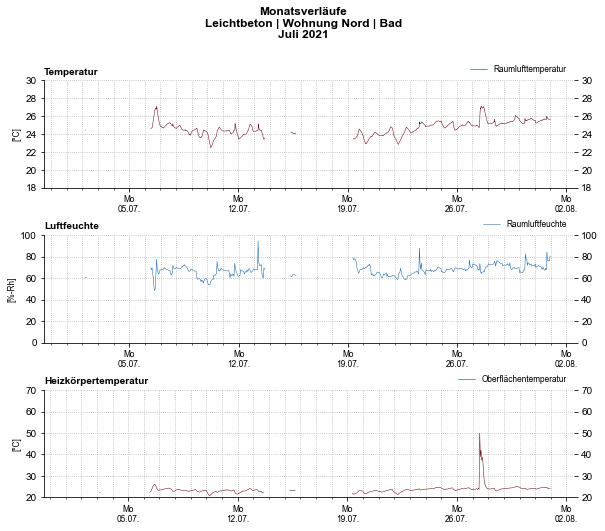

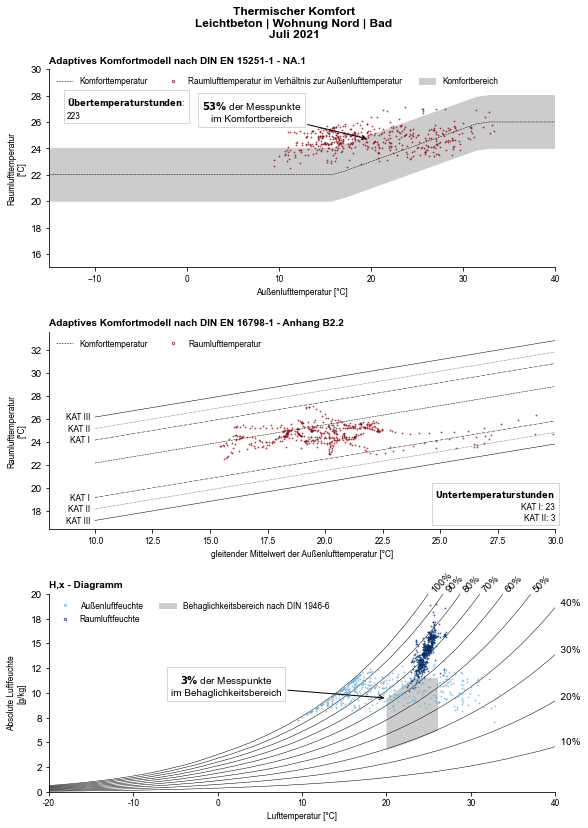

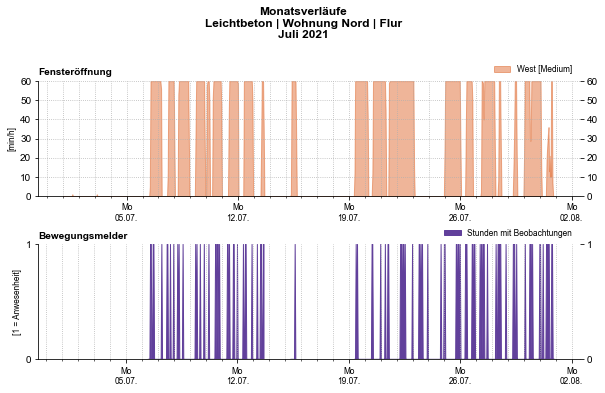

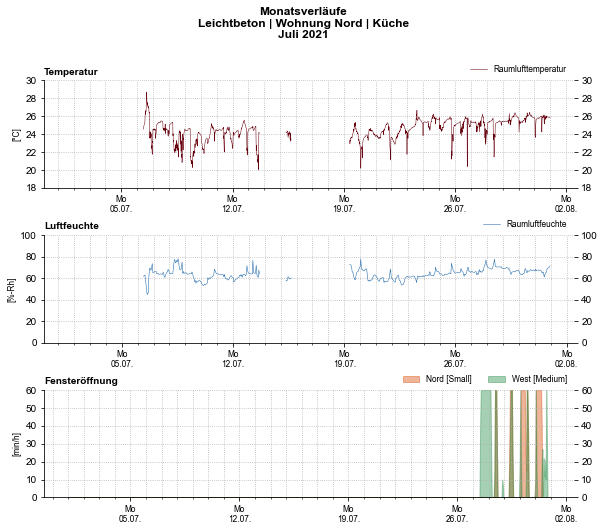

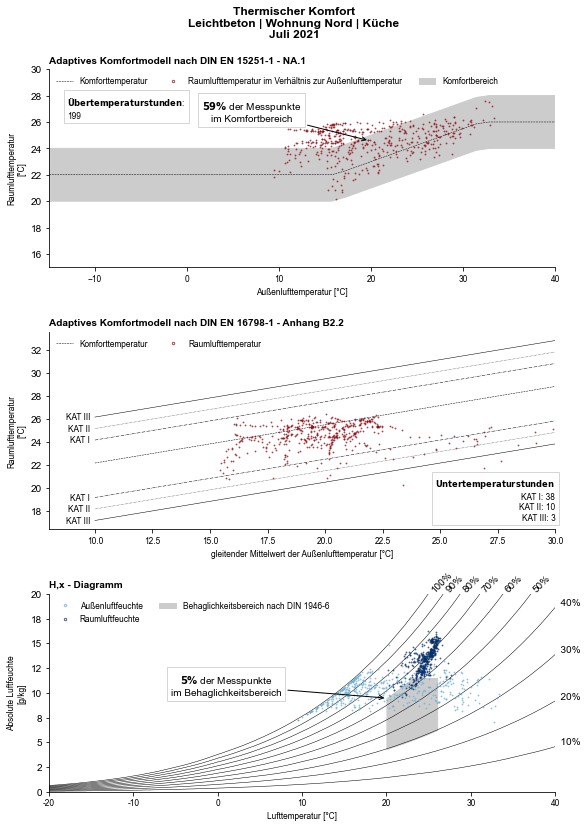

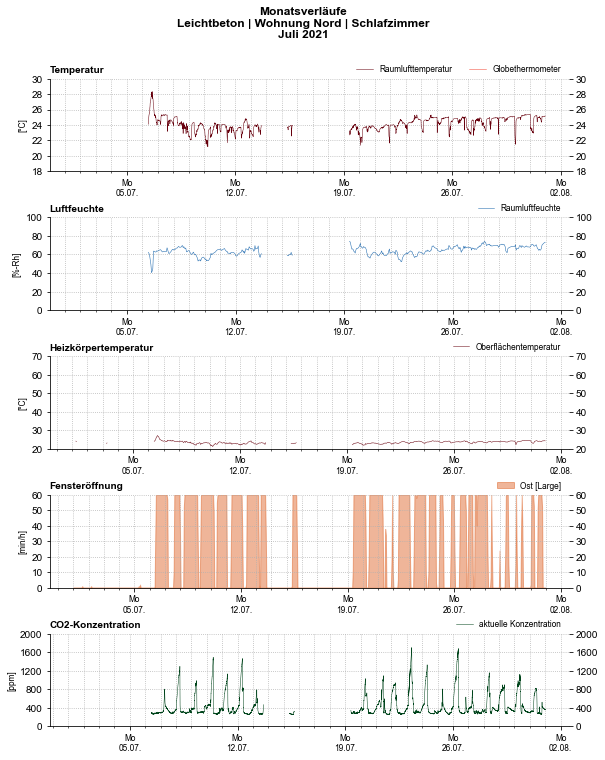

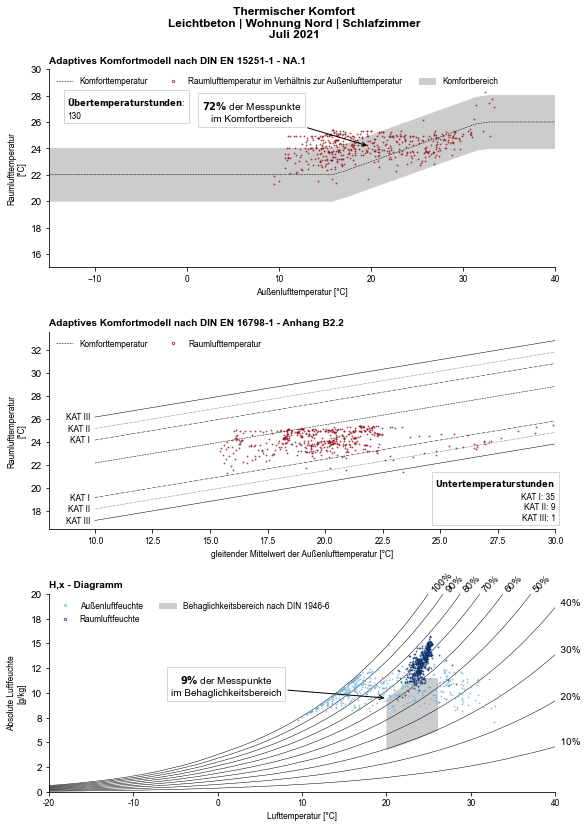

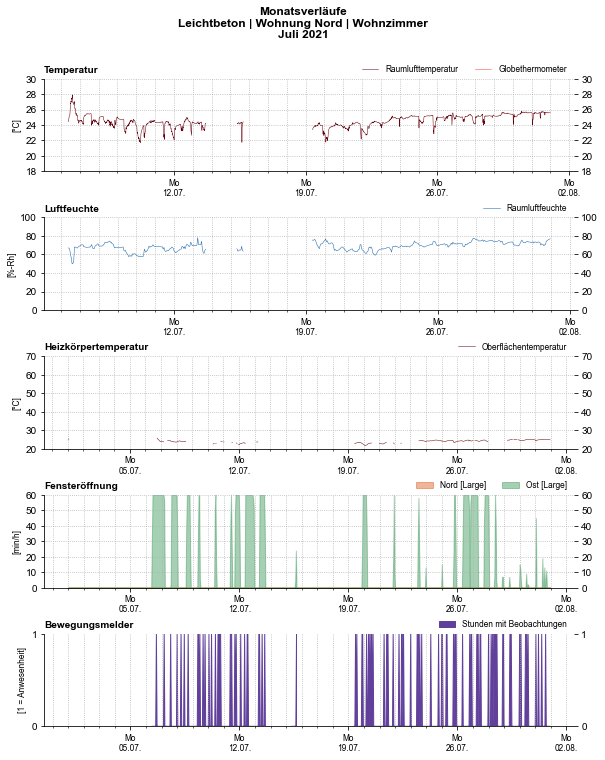

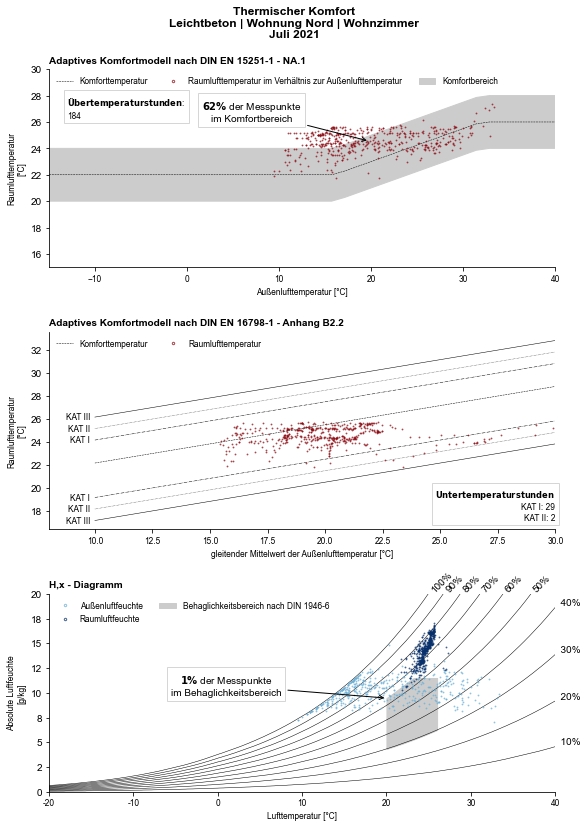

In [5]:
if ex:
    buid = eb.buid
    wohnungen = eb.wohnungen
    rooms = eb.rooms    
else:
    buid = ['LB']
    wohnungen = ['N']
    rooms = eb.rooms
    focus_month = dt.date(2021,7,1)

mode = 0     #0 = beides,  1 = nur Monatsübersicht, 2 = nur Comfort

for b, bui in enumerate(buid):
    if ex: print(f'--- plotting {eb.buid[bui]} ---')
    for date, ind in IND[bui].groupby(by=[IND[bui].index.month, IND[bui].index.year]):
        date = dt.date(date[1], date[0], 1)
        if not ex and date != focus_month:
            continue
        else:
            amb = AMB[AMB.index.month == date.month]
            for a, app in enumerate(wohnungen):
                path = os.path.join(eb.dir_results,'Thermischer Comfort',eb.buid[bui],eb.wohnungen[app])
                if not os.path.exists(path): os.makedirs(path)
                try:
                    with PdfPages(os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_{date:%y%m}.pdf'))) as comf_pdf:
                        path = os.path.join(eb.dir_results,'Monatliche Übersicht',eb.buid[bui],eb.wohnungen[app])
                        if not os.path.exists(path): os.makedirs(path)
                        with PdfPages(os.path.join(path,f'{bui}_{app}_Raumklima_{date:%y%m}.pdf')) as pdf:
                            for room in rooms:
                                if room in ind[app].columns.get_level_values(level=0).unique():
                                    if mode == 0 or mode == 1:
                                        if not ex:
                                            print(f'--- plotting {eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]} ---')
                                        #define figure
                                        fig = plt.figure(figsize=style.din_a4, constrained_layout=True)
                                        gs = GridSpec(6, 1, figure=fig)
                                        axs=[]
                                        i=0
                                        fig.suptitle(f'Monatsverläufe\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
                                        #----#1: Temperature ----
                                        sensor = 'trh_Tair'
                                        df = ind[app][room].filter(like=sensor)
                                        if len(df.columns) > 0:
                                            if len(df.columns) > 1:
                                                df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                                                df.drop(df.columns[1],axis=1,inplace=True)
                                            axs.append(fig.add_subplot(gs[i,:]))

                                            axs[i].plot(df.resample('15min').last(),label = 'Raumlufttemperatur')
                                            axs[i].set_ylim(15,30)

                                            ###### Warum weg?
                                            sensor = 'pt_Tsk'
                                            df = ind[app][room].filter(like=sensor)
                                            if len(df.columns) > 0:
                                                axs[i].plot(df,label = 'Globethermometer')
                                            ut.recolor_lines(axs[i], style.c_temp)

                                            axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
                                            axs[i].set_ylabel('[°C]')
                                            set_y_ticks(axs[i],18,30,2)
                                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                            axs[i].grid(axis="y", ls='dotted')
                                            axs[i].grid(axis='x',which='both', linestyle='dotted')
                                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                            i+=1

                                        #----#2: Humidity ----
                                        sensor = 'trh_RH'
                                        df = ind[app][room].filter(like=sensor)
                                        if len(df.columns) > 0:
                                            if len(df.columns) > 1:
                                                df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                                                df.drop(df.columns[1],axis=1,inplace=True)
                                            df.columns = ['Rh']
                                            Rh = df.replace([' ',''], np.NAN)
                                            ## Korrektur Messwert:
                                            Rh = Rh - KORREKTUR_RH[bui]
                                            axs.append(fig.add_subplot(gs[i, :]))
                                            axs[i].plot(Rh.resample('H').last(),label = 'Raumluftfeuchte')
                                            ut.recolor_lines(axs[i], style.c_hum)

                                            axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
                                            axs[i].set_ylabel('[%-Rh]')

                                            set_y_ticks(axs[i],0,100,20)
                                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                            axs[i].grid(axis="y", ls='dotted')
                                            axs[i].grid(axis='x',which='both', linestyle='dotted')
                                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                            i+=1

                                        #----#3: Heizkörpertemperatur ----
                                        sensor = 'pt_Thk'
                                        df = ind[app][room].filter(like=sensor)
                                        if len(df.columns) > 0:
                                            axs.append(fig.add_subplot(gs[i,:]))
                                            axs[i].plot(df.resample('H').last(),label = 'Oberflächentemperatur')
                                            ut.recolor_lines(axs[i], style.c_temp)
                                            axs[i].set_title('Heizkörpertemperatur', fontweight = 'bold',loc='left')
                                            axs[i].set_ylabel('[°C]')
                                            set_y_ticks(axs[i], 20, 70, 10)
                                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                            axs[i].grid(axis="y", ls='dotted')
                                            axs[i].grid(axis='x',which='both', linestyle='dotted')
                                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                            i+=1
                                        else:
                                            pass

                                        #----#6: Windows ----
                                        windows = ind[app][room].filter(like='reed')
                                        c = [mpl.cm.Oranges(0.75),mpl.cm.Greens(0.75)]
                                        if len(windows.columns) > 0:
                                            axs.append(fig.add_subplot(gs[i, :]))
                                            windows.replace(['Closed','Open'],[0,1],inplace=True)
                                            windows = windows.resample('H').sum()
                                            labels, patches = [], []
                                            for w,col in enumerate(windows.columns):
                                                axs[i].fill_between(x=windows.index, y1=windows[col], color=c[w], alpha=0.4)
                                                #axs[i].plot(windows[col], color=c[w])
                                                patches.append(mpl.patches.Patch(color=c[w], alpha=0.4))
                                                ori = KOMPASS[col.split('_')[0]]
                                                size = re.search(r'\[(.*?)\]', col)[0]
                                                labels.append(f'{ori} {size}')
                                            axs[i].legend(handles=patches, labels=labels,loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                            axs[i].set_title('Fensteröffnung', fontweight = 'bold',loc='left')
                                            axs[i].set_ylabel('[min/h]')
                                            set_y_ticks(axs[i], 0, 60, 10)
                                            axs[i].grid(axis="y", ls='dotted')
                                            axs[i].grid(axis='x',which='both', linestyle='dotted')
                                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                            i+=1
                                        else:
                                            pass
                                        #----#4: Bewegungsmelder ----
                                        sensor = '_md'
                                        df = ind[app][room].filter(like=sensor)
                                        if len(df.columns) > 0:
                                            df.columns = ['md']

                                            axs.append(fig.add_subplot(gs[i,:]))
                                            df = df.resample('H').max()
                                            for c, col in enumerate(df.columns):
                                                axs[i].fill_between(df.index, df[col], color=mpl.cm.Purples(0.8), label='Stunden mit Beobachtungen')
                                            #ut.recolor_lines(axs[i], 'Purples_r' ,minint=0 ,maxint=0.8)
                                            set_y_ticks(axs[i],0,1,1)
                                            #axs[i].set_ylim(0,60)
                                            axs[i].set_title('Bewegungsmelder', fontweight = 'bold',loc='left')
                                            axs[i].set_ylabel('[1 = Anwesenheit]')
                                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                            #axs[i].grid(axis="y", ls='dotted')
                                            axs[i].grid(axis='x',which='both', linestyle='dotted')
                                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                            i+=1
                                        else:
                                            pass

                                        #----#5: CO2 ----
                                        sensor = 'co2'
                                        if len(ind[app][room].filter(like=sensor).columns) == 0:
                                            pass
                                        else: 
                                            sensors = list(ind[app][room].filter(like=sensor).columns)
                                            for sensor in sensors:
                                                if sensor.count('_') == 1:
                                                    sensors = sensor

                                            axs.append(fig.add_subplot(gs[i, :]))
                                            axs[i].plot(ind[app][room][sensors],label = 'aktuelle Konzentration')

                                            ut.recolor_lines(axs[i], style.c_co2)

                                            axs[i].set_title('CO2-Konzentration', fontweight = 'bold',loc='left')
                                            axs[i].set_ylabel('[ppm]')
                                            set_y_ticks(axs[i],0,2000,400)
                                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                            axs[i].grid(axis="y", ls='dotted')
                                            axs[i].grid(axis='x',which='both', linestyle='dotted')
                                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                            i+=1

                                        for ax in axs:
                                            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m.'))
                                            ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
                                            #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%a'))
                                            ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
                                            #ax.spines['bottom'].set_visible(True)

                                        pdf.savefig(fig)
                                        if ex: plt.clf()

                                    ### Comfort PDF
                                    if mode == 0 or mode == 2:
                                        if room != 'F':
                                            tamb = amb['T_amb'].resample('H').last()
                                            tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                                            rhamb = amb['Rh_amb'].resample('H').last()

                                            test = ind[app][room].filter(like='trh_Tair (°C)')
                                            if len(test.columns) == 1:
                                                troom = test.resample('H').last().dropna()
                                            elif len(test.columns) == 2:
                                                test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                                test.drop(test.columns[1],axis=1,inplace=True)
                                                troom = test.resample('H').last().dropna()
                                            else:
                                                print(f'{bui}-{app}-{room} | Temperatursensor konnte nicht zugeordnet werden.')
                                                troom = None

                                            test = ind[app][room].filter(like='trh_RH (%)')
                                            if len(test.columns) == 1:
                                                rhroom = test.resample('H').last().dropna()                                        
                                            elif len(test.columns) == 2:
                                                test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                                test.drop(test.columns[1],axis=1,inplace=True)
                                                rhroom = test.resample('H').last().dropna()
                                            else:
                                                print(f'{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                                rhroom = None

                                            if (isinstance(troom, pd.DataFrame) and len(troom.index) > 0) and (isinstance(rhroom, pd.DataFrame) and len(rhroom.index) > 0):
                                                fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = style.din_a4)
                                                fig.suptitle(f'Thermischer Komfort\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
                                                #----#7.1: Thermal Comfort 1 ----
                                                if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb,(pd.Series, pd.DataFrame)):
                                                    graphs.thermal_comfort_1(
                                                        TAMB = tamb,
                                                        TROOM = troom,
                                                        ax = ax1,
                                                        mode = 'air',
                                                        legend_ms=3
                                                        )  

                                                #----#7.2: Thermal Comfort 2 ----
                                                if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(tamb_g24,(pd.Series, pd.DataFrame)) and len(tamb_g24.index) > 0):
                                                    graphs.thermal_comfort_2(
                                                        TAMBG24 = tamb_g24,
                                                        TROOM = troom,
                                                        ax=ax2,
                                                        mode = 'air',
                                                        legend_ms=3
                                                        )

                                                #----#7.3: H,x - Diagramm ----
                                                if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(rhroom,(pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                                    graphs.comfort_hx_diagramm(
                                                        t1 = troom,
                                                        rh1 = rhroom,
                                                        rh2 = rhamb,
                                                        t2 = tamb,
                                                        ax = ax3,
                                                        legend_ms=3
                                                        )
                                                fig.tight_layout()
                                                comf_pdf.savefig(fig)
                                                if ex: plt.clf()
                except Exception as e:
                    print(f'ACHTUNG! {bui} {app} {room} konnte nicht ausgewertet werden. Siehe Exception:')
                    print(e)
            if not ex: break
print('Done!')

## Wetterdaten
____

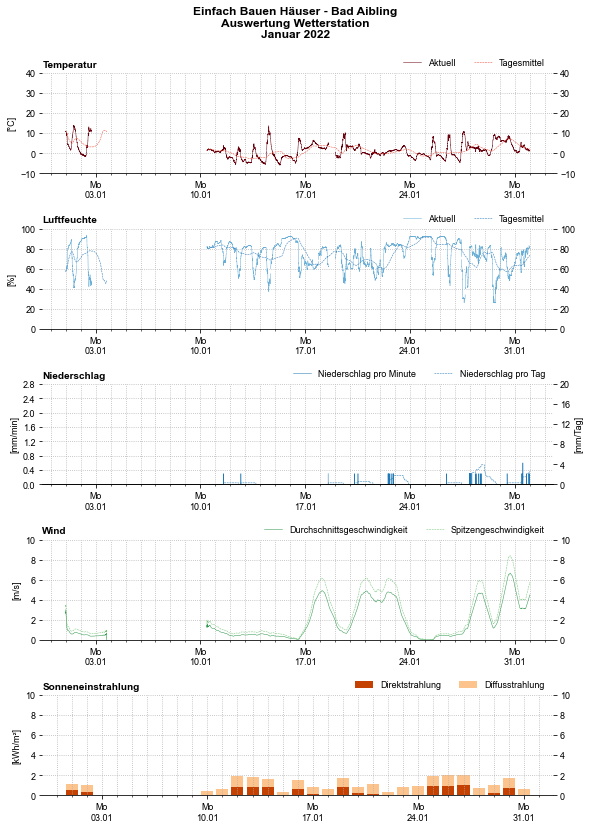

In [16]:
with PdfPages(os.path.join(eb.dir_results,'Wetterstation','Wetter_monatlich.pdf')) as pdf:
    for date, amb in AMB.groupby(by=[AMB.index.month, AMB.index.year]):
        date = dt.date(date[1], date[0], 1)
        fig, axs = plt.subplots(5,1,figsize=style.din_a4)
        fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
        i=0
        #----#1: Temperaturen ----
        axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[°C]')
        set_y_ticks(axs[i],-10,40,10)
        axs[i].plot(amb.T_amb,label='Aktuell')
        axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        ut.recolor_lines(axs[i], style.c_temp)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#2: Luftfeuchte ----
        axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[%]')
        set_y_ticks(axs[i],0,100,20)
        axs[i].plot(amb.Rh_amb,label='Aktuell')
        axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        ut.recolor_lines(axs[i], 'Blues', minint=0.5,maxint=1)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Niederschlag ----
        # Plot aktueller Niederschlag (pro Minute)
        axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[mm/min]')
        set_y_ticks(axs[i],0,2,0.4)
        axs[i].plot(amb.rain.diff(),label='Niederschlag pro Minute')
        han,lab = axs[i].get_legend_handles_labels()
        axs[i].grid(axis='y', ls = 'dotted')
        #axs[i].legend(loc='upper center',ncol=5,frameon=False)

        #Plot summierter Niederschlag pro Tag
        i+=1
        axs = np.insert(axs,i,axs[i-1].twinx())
        axs[i].set_ylabel('[mm/Tag]')
        axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
        #axs[i].grid(axis='y', ls = 'dashed')
        set_y_ticks(axs[i],0,20,4)
        han2,lab2 = axs[i].get_legend_handles_labels()
        lab += lab2
        han += han2

        axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Wind ----

        axs[i].set_title('Wind', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[m/s]')
        axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Durchschnittsgeschwindigkeit')  
        axs[i].plot(amb.gustspeed.rolling('D').mean(),label = 'Spitzengeschwindigkeit',linestyle='dashed')  
        ut.recolor_lines(axs[i], 'Greens_r', minint=0.3,maxint=0.7)
        axs[i].grid(axis='y', ls = 'dotted')
        set_y_ticks(axs[i],0,10,2)
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1

        #----#4: Globalstrahlung ----
        
        axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[kWh/m²]')
        set_y_ticks(axs[i],0,10,2)
        df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000

        #axs[i].bar(df_p.index, df_p['global'], label='global', color=plt.cm.Accent(0), align='edge')
        #axs[i].bar(df_p.index,df_p['direct'],bottom = df_p['global'], label='direct',color=plt.cm.Accent(0.5))

        axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direktstrahlung')
        axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffusstrahlung')

        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m'))
            #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%a'))
            ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
            ax.grid(axis='x',which='both', linestyle='dotted')
            ax.spines['bottom'].set_visible(True)
            
        fig.tight_layout()
        pdf.savefig(fig)
        if not ex: break

In [5]:
winddir = {'E':4, 'ENE':3, 'ESE':5, 'N':0, 'NE':2, 'NNE':1, 'NNW':15, 'NW':14, 'S':8, 'SE':6, 'SSE':7,
       'SSW':9, 'SW':10, 'W':12, 'WNW':13, 'WSW':11}
winddir = dict(sorted(winddir.items(), key=lambda item: item[1]))
wind = dict(zip(winddir.keys(), np.linspace(0,2*np.pi,16,endpoint=False)))

W =  AMB.loc[:,['winddir','windspeed','gustspeed']]
W['dir'] = W.winddir.replace(wind)

bins = np.linspace(W.windspeed.min(), W.windspeed.max(), 6)
labels = ['{} - {} m/s'.format(round(bins[i-1],1),round(bins[i],1)) for i in range(1,6)]

columns = ['bin{}'.format(i) for i in range(6)]
rose = pd.DataFrame(index=W.winddir.value_counts().index, columns=columns)

for i in range(1,6):
    rose[columns[i]] = W[(W.windspeed > bins[i-1]) & (W.windspeed <= bins[i])].groupby("winddir").size()/W.groupby('winddir').size().sum()
rose = rose*100

rose['theta'] = rose.index
rose.theta.replace(wind,inplace=True)
rose['deg'] =  rose.theta.apply(np.rad2deg)
rose.replace(np.nan,0,inplace=True)

fig, ax = plt.subplots(figsize = (6,6), subplot_kw={'projection': 'polar'})

fig.suptitle('Windrose',fontweight='bold')

w = 2*np.pi/(16)

_colors = plt.cm.Accent(np.linspace(0,1,5))

ax.bar(rose.theta,rose.bin1,width = w, bottom=0, label = labels[0],color=_colors[0],alpha=0.75)
ax.bar(rose.theta,rose.bin2,width = w, bottom=rose.bin1, label = labels[1],color=_colors[1],alpha=0.75)
ax.bar(rose.theta,rose.bin3,width = w, bottom=rose.bin1+rose.bin2, label = labels[2],color=_colors[2],alpha=0.75)
ax.bar(rose.theta,rose.bin4,width = w, bottom=rose.bin1+rose.bin2+rose.bin3, label = labels[3],color=_colors[3],alpha=0.75)
ax.bar(rose.theta,rose.bin5,width = w, bottom=rose.bin1+rose.bin2+rose.bin3+rose.bin4, label = labels[4],color=_colors[4],alpha=0.75)

ax.set_theta_direction(-1)

ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False))
ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False)+0.25*np.pi,minor=True)
ax.set_xticklabels(['NO','SO','SW','NW'],minor=True)
ax.set_xticklabels(['Nord','Ost','Süd','West'],fontweight='bold')

ax.set_theta_zero_location('N')

ax.grid(linestyle='dashed')
ax.grid(linestyle='dotted',which='minor')

ax.set_rlabel_position(60)
ax.legend(loc=3,frameon=True)
ax.yaxis.set_major_locator(ticker.FixedLocator([5,10,15,20]))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

fig.tight_layout()

if ex:
    ut.export(fig,filepath=os.path.join(eb.dir_results,'Wetterstation'),filename='Windrose', extlist=['pdf','png'])

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Wetterstation\Windrose.pdf saved!
C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Wetterstation\Windrose.png saved!


## Lüftung
___

In [6]:
for bui in eb.buid:
    ind = IND[bui].loc['2021-06-01':]
    fig = plt.figure(figsize=style.din_a4_landscape,constrained_layout=True)
    gs = GridSpec(3, 4, figure=fig)
    axs=[]

    fig.suptitle('{}'.format(eb.buid[bui]),fontweight='bold')
    for i, app in enumerate(eb.wohnungen):
        axs.append([])
        dfs = []

        for room in eb.rooms:
            try:
                idx = []
                df = ind[app][room].filter(like='reed')                    
                """for window in df.columns.str.split(' ',expand=True).droplevel(level=1).unique():
                    if len(df.filter(like=window).columns) > 1:
                        df.iloc[:,1] = df.filter(like=window).iloc[:,1].fillna(df.filter(like=window).iloc[:,0])
                        df.drop(df.filter(like=window).iloc[:,0].name,axis=1,inplace=True)"""
                df.replace(['Closed','Open'],[0,1],inplace=True)
                for f,col in enumerate(df.columns):
                    t = col.split(' ')
                    ori = t[0].split('_')[0]
                    idx.append((room,'{}{}_{}'.format(ori,f, t[1])))
                df.columns = pd.MultiIndex.from_tuples(idx)
                dfs.append(df)
            except:
                continue

        df = pd.concat(dfs).resample('1min').max()

        n=len(df.columns)
        df1 = df.sum(axis=1)
        df1 = df1[df1 > 0]
        counts = df1.value_counts(normalize=True)
        gl = round(df1.dropna().mean(),1)
        ventkoeff = round(df.max(axis=1).value_counts(normalize=True)[1.0]*100,1)    #Anteil der Zeit in der Fenster geöffnet sind. Gewichtet nach Anzahl der Fenster.
        
        ### Histogramm
        j=0
        axs[i].append(fig.add_subplot(gs[i, 0]))
        df3 = df.sum(axis=1)
        df3.hist(ax = axs[i][j],bins=np.linspace(0,n+1,n+2), grid = False)
        axs[i][j].set_xticks(np.linspace(0,n,n+1)+0.5)
        axs[i][j].set_xticklabels(range(n+1))
        #ut.ticks_to_hours(axs[i][j])
        axs[i][j].set_ylabel('Zeit [h]')
        axs[i][j].set_title('Häufigkeitsverteilung ')
        ###Timeline
        j+=1
        axs[i].append(fig.add_subplot(gs[i, 1:]))
        axs[i][j].set_title('Wohnung {}'.format(eb.wohnungen[app]),fontweight='bold')
        axs[i][j].text(
                0.0,
                0.95, 
                'Fenster pro Wohnung: {}\nZeit mit min. einem geöffnetem Fenster: {} %\nDurschnittlich gleichzeitig geöffnete Fenster: {}\nMaximal gleichzeitig geöffnete Fenster: {}'.format(n,ventkoeff,gl,int(df1.max())),      
                fontsize = 'large', 
                style='normal', 
                ha = 'left', 
                va = 'top',
                transform=axs[i][j].transAxes,
                bbox=style.eb_bbox, 
                )
        axs[i][j].set_ylim(0,24*60*n)
        axs[i][j].set_ylabel('Zeit\n' + r'$[n_{Fenster}*min_{geöffnet}]$')
        df2 = df.sum(axis=1).resample('D').sum()
        axs[i][j].bar(df2.index, df2)
        axs[i][j].plot(df2.rolling('30D').mean(),'r--')

    for ax in axs:
        ax[1].xaxis.set_major_locator(mdates.MonthLocator())
        ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if ex:
        ut.export(fig,filepath=os.path.join(eb.dir_results,'Lüftungsverhalten'),filename=f'{bui}_Übersicht', extlist=['pdf'])

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Lüftungsverhalten\MH_Übersicht.pdf saved!
C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Lüftungsverhalten\MW_Übersicht.pdf saved!
C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Lüftungsverhalten\LB_Übersicht.pdf saved!
